## Imports

In [3]:
from JSU_lib import *

In [1]:
import os
import re
import time
import pickle
import numpy as np
import pandas as pd 

import warnings
import logging
warnings.filterwarnings('ignore') # ignores warnings
logging.disable(logging.CRITICAL) # disables logging

from prointvar.pdbx import PDBXreader

## Functions

In [4]:
def parse_fpocket_output(filepath):
    # Read the content of the file
    with open(filepath, 'r') as file:
        data = file.read()
    
    # Regular expression to split the input data by "Pocket <number> :"
    pockets = re.split(r'Pocket \d+ :', data)
    pockets = [pocket.strip() for pocket in pockets if pocket.strip()]  # Remove any empty entries

    if pockets == []:
        return pd.DataFrame()

    # List to hold each pocket's dictionary of metrics
    pocket_list = []
    detail_keys = set()

    # Regex pattern to find all key-value pairs in each pocket's text block
    pattern = re.compile(r'(.*?):\s*([-\d\.]+)')

    for pocket in pockets:
        # Dictionary to store the data for this pocket
        pocket_data = {}
        
        # Find all key-value pairs in this pocket
        details = pattern.findall(pocket)
        for key, value in details:
            cleaned_key = key.strip().lower().replace(' - ', '_').replace(' ', '_').replace('.', '').replace('__', '_')
            pocket_data[cleaned_key] = float(value)
            detail_keys.add(cleaned_key)

        pocket_list.append(pocket_data)

    # Convert list of dictionaries into a DataFrame
    df = pd.DataFrame(pocket_list)

    # Rename the DataFrame columns to the desired names
    df.columns = [
        'score_fpocket', 'drug_score', 'n_alpha_spheres',
        'total_sasa', 'polar_sasa', 'apolar_sasa', 'volume_fpocket',
        'mean_hydro_density', 'mean_alpha_sphere_r',
        'mean_alpha_sphere_solvent_acc', 'apolar_alpha_sphere_prop',
        'hydro_score', 'vol_score', 'polarity_score', 'charge_score',
        'prop_polar_atoms', 'alpha_sphere_density', 'max_dist', 'flexibility'
    ]

    # Add ID column, starting at 1 and incrementing by 1 for each row
    df["ID"] = list(range(1, len(df)+1))

    # Add a RANK column based on the 'drug_score', highest first
    df['RANK_fpocket'] = df['score_fpocket'].rank(ascending=False, method='first').astype(int)

    return df

## Input data

In [5]:
deep_pocket_dir = "/Users/2394007/Documents/PHD/LOCAL/JSU_site_predictors/DATA/deeppocket_out"

In [6]:
fs = os.listdir(deep_pocket_dir) #57143
print(len(fs))

57143


In [7]:
remove_extensions = ["dx", "gninatypes"]

In [8]:
fs = [f for f in fs if f.split(".")[-1] not in remove_extensions] # 39904
print(len(fs))

39904


In [9]:
fs = [f for f in fs if not f.endswith(".clean.pdb")] #35469
print(len(fs))

35469


In [10]:
fs = [f for f in fs if not f.endswith("nowat.pdb")] #31024
print(len(fs))

31024


In [11]:
deeppocket_pdbs = sorted([f for f in fs if f.endswith(".pdb")]) #26587
print(len(deeppocket_pdbs))

26587


In [12]:
deeppocket_pdbs[:2]

['1a52_A.clean_nowat_pocket1.pdb', '1a52_A.clean_nowat_pocket10.pdb']

In [13]:
deeppocket_out_dirs = sorted([f for f in fs if f.endswith("out")])
print(len(deeppocket_out_dirs))

4435


In [14]:
deeppocket_out_dirs[:2]

['1a52_A.clean_nowat_out', '1a5h_B.clean_nowat_out']

## Get DeepPocket data

In [15]:
clean_rep_chains_dir = "/Users/2394007/Documents/PHD/LOCAL/JSU_site_predictors/DATA/clean_rep_chains"
clean_rep_chains_dir = "/Users/2394007/Documents/PHD/LOCAL/JSU_site_predictors/DATA/trans_rep_chains"

In [16]:
errors = []
success = []
no_pockets = []
fpocket_dfs = []

### Phase I: get fpocket pockets data

In [17]:
for i, fpocket_dir in enumerate(deeppocket_out_dirs):
    
    if i % 500 == 0:
       print(i) 
    
    if fpocket_dir in success:
        continue
        
    try:
        fpocket_dir_path = os.path.join(deep_pocket_dir, fpocket_dir)
        input_name = fpocket_dir[:-4]
        file_path = os.path.join(fpocket_dir_path, f'{input_name}_info.txt')
        pocket_df = parse_fpocket_output(file_path)
        
        if pocket_df.empty:
            #print(f'No pockets in {input_name}')
            if fpocket_dir not in no_pockets:
                no_pockets.append(fpocket_dir)
            continue
        
        pocket_df["rep_chain"] = input_name.split(".")[0]
        success.append(fpocket_dir)
        fpocket_dfs.append(pocket_df)
    except:
        raise
        print(f'ERROR with {fpocket_dir}')
        #raise
        if fpocket_dir not in errors:
            errors.append(fpocket_dir)

    #break
        
        

0
500
1000
1500
2000
2500
3000
3500
4000


In [18]:
print(len(success)) #4389
print(len(no_pockets)) #46
print(len(fpocket_dfs)) #4389
print(len(errors)) #0

4389
46
4389
0


In [19]:
[el.split(".")[0] for el in errors]

[]

In [20]:
all_fpockets = pd.concat(fpocket_dfs).reset_index(drop = True)

In [21]:
fpocket_cols = ["rep_chain", "ID", "RANK_fpocket", "score_fpocket", "volume_fpocket"] # "drug_score", "total_sasa",

In [22]:
all_fpockets[fpocket_cols].head(10) # this should be the same as plain fpocket

,rep_chain,ID,RANK_fpocket,score_fpocket,volume_fpocket
0,1a52_A,1,1,0.276,1190.393
1,1a52_A,2,2,0.051,458.269
2,1a52_A,3,3,0.027,443.436
3,1a52_A,4,4,0.012,292.336
4,1a52_A,5,5,0.010,737.698
5,1a52_A,6,6,0.001,747.562
6,1a52_A,7,7,-0.031,340.671
7,1a52_A,8,8,-0.048,359.478
8,1a52_A,9,9,-0.054,543.718
9,1a52_A,10,10,-0.063,245.027


In [23]:
len(all_fpockets) #84303

84303

In [43]:
#all_fpockets.to_pickle("./results/fpocket_pockets.pkl")

In [94]:
#all_fpockets = pd.read_pickle("./results/fpocket_pockets.pkl")

### Phase II: extract DeepPocket re-scoring and re-ranking

In [24]:
def extract_data_from_file(file_path):
    float_data = {}
    order_data = {}
    with open(file_path, 'r') as file:
        for i, line in enumerate(file, 1):
            parts = line.split()
            index = int(parts[0])
            floats = tuple(round(float(x), 2) for x in parts[1:4])
            float_data[index] = floats
            order_data[index] = i
    return float_data, order_data

def extract_values_by_line(file_path):
    with open(file_path, 'r') as file:
        for i, line in enumerate(file, 1):
            # Strip newline characters and any surrounding whitespace
            cleaned_line = line.strip()
            # Directly use the cleaned line as the value
            values = cleaned_line.split(",")
        vals_dict = {i+1: float(el) for i, el in enumerate(values)}
    return vals_dict

In [31]:
len(success) #4389

4389

In [32]:
len(deeppocket_out_dirs) #4435

4435

In [27]:
rank_errors = []
pocket_centres_dict = {}
pocket_new_score_dict = {}
pocket_new_rank_dict = {}
for i, fpocket_dir in enumerate(deeppocket_out_dirs):
    
    if i % 500 == 0:
       print(i) 
    
    if fpocket_dir not in success:
        #print(fpocket_dir)
        continue
        
    try:
        fpocket_dir_path = os.path.join(deep_pocket_dir, fpocket_dir)
        input_name = fpocket_dir.split(".")[0]
        #print(input_name)
        pockets_subdir = os.path.join(fpocket_dir_path, "pockets")
        centers_ranked_path = os.path.join(pockets_subdir, "bary_centers_ranked.types")
        ranked_scores_path = os.path.join(pockets_subdir, "bary_centers_confidence.txt")
        centre_dict, rank_dict = extract_data_from_file(centers_ranked_path)
        scores_dict = extract_values_by_line(ranked_scores_path)
    
        centre_dict2 = {(input_name, k): v for k, v in centre_dict.items()} # SECOND KEY HERE IS THE ORIGINAL FPOCKET RANKING
        rank_dict2 = {(input_name, k): v for k, v in rank_dict.items()} # SECOND KEY HERE IS THE ORIGINAL FPOCKET RANKING
        scores_dict2 = {(input_name, k): v for k, v in scores_dict.items()} # SECOND KEY HERE IS NEW RANKING
    
        for k, v in centre_dict2.items():
            pocket_centres_dict[k] = v
    
        for k, v in rank_dict2.items():
            pocket_new_rank_dict[k] = v
    
        for k, v in scores_dict2.items():
            pocket_new_score_dict[k] = v
    
    
    # if i > 5:
    #     break
    except:
        print(f'ERROR with {fpocket_dir}')
        #raise
        if fpocket_dir not in errors:
            rank_errors.append(fpocket_dir)


0
500
1000
1500
2000
2500
3000
3500
4000


In [28]:
len(pocket_centres_dict) #84303

84303

In [29]:
len(pocket_new_score_dict) #84303

84303

In [30]:
len(pocket_new_rank_dict) #84303

84303

In [36]:
all_fpockets["RANK_deep"] = all_fpockets.set_index(["rep_chain", "ID"]).index.map(pocket_new_rank_dict)

all_fpockets["score_deep"] = all_fpockets.set_index(["rep_chain", "RANK_deep"]).index.map(pocket_new_score_dict)

In [37]:
all_fpockets["centre_deep1"] = np.nan # THIS IS THE BARYCENTRE OF THE FPOCKET CANDIDATE AS CALCULATED BY DEEPPOCKET (PRE-SEGMENTATION)
centres = []
errs = 0
err_chains = []
for i, row in all_fpockets.iterrows():
    try:
        centre = pocket_centres_dict[(row.rep_chain, row.ID)]
        centres.append(centre)
    except:
        errs += 1
        centres.append(np.nan)
        err_chains.append(row.rep_chain)
print(errs) #0

0


In [38]:
all_fpockets["centre_deep1"] = centres

In [39]:
all_fpockets[["rep_chain", "ID", "RANK_fpocket", "score_fpocket", "volume_fpocket", "RANK_deep", "score_deep", "centre_deep1"]].head(3)

,rep_chain,ID,RANK_fpocket,score_fpocket,volume_fpocket,RANK_deep,score_deep,centre_deep1
0,1a52_A,1,1,0.276,1190.393,1,0.973307,"(101.66, 14.74, 99.13)"
1,1a52_A,2,2,0.051,458.269,3,0.197817,"(104.03, 24.26, 104.0)"
2,1a52_A,3,3,0.027,443.436,2,0.200280,"(93.83, 28.87, 88.54)"


## Get pocket residues (FPOCKET POCKETS)

In [40]:
errors = []
success = []
no_pockets = []
fpocket_ress_dict = {}
centres_dict = {}

In [62]:
import importlib
import JSU_lib
importlib.reload(JSU_lib)
from JSU_lib import *

In [41]:
for i, fpocket_dir in enumerate(deeppocket_out_dirs):
    
    if i % 100 == 0:
        print(i) 
    
    if fpocket_dir in success:
        continue
        
    try:
        fpocket_dir_path = os.path.join(deep_pocket_dir, fpocket_dir)
        input_name = fpocket_dir[:-4]
        rep_chain = input_name.split(".")[0]
        #print(input_name)
        pockets_dir = os.path.join(fpocket_dir_path, "pockets")
        pockets_pdb = [el for el in os.listdir(pockets_dir) if el.endswith(".pdb")]
        #print(pockets_pdb)
        for pocket_file in pockets_pdb:
            pocket_id = int(pocket_file.split("_")[0][6:])
            pocket_path = os.path.join(pockets_dir, pocket_file)
            pocket_df = PDBXreader(inputfile=pocket_path).atoms(format_type="pdb", excluded=())
            pocket_ress = sorted(pocket_df.label_seq_id_full.unique().tolist(), key=custom_sort)
            fpocket_ress_dict[(rep_chain, pocket_id)] = pocket_ress

            pocket_coords = np.array(list((zip(pocket_df.Cartn_x, pocket_df.Cartn_y, pocket_df.Cartn_z))))
            center_of_mass = np.mean(pocket_coords, axis=0)
            centres_dict[(rep_chain, pocket_id)] = tuple([round(v, 3) for v in center_of_mass])
            
        #break
        
        if pocket_df.empty:
            #print(f'No pockets in {input_name}')
            if fpocket_dir not in no_pockets:
                no_pockets.append(fpocket_dir)
            continue
            
        success.append(fpocket_dir)
    except:
        raise
        print(f'ERROR with {fpocket_dir}')
        if fpocket_dir not in errors:
            errors.append(fpocket_dir)
    #break

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400


In [42]:
print(len(success)) #4435
print(len(no_pockets)) #0
print(len(fpocket_ress_dict)) #84303
print(len(centres_dict)) #84303
print(len(errors)) #0

4435
0
84303
84303
0


In [43]:
success_reps = [el.split(".")[0] for el in success]

In [44]:
LIGYSIS_reps = read_from_pickle("./results/LIGYSIS_3448_chains.pkl")

In [45]:
len(set(LIGYSIS_reps).intersection(set(success_reps)))

3448

In [43]:
#save_to_pickle(fpocket_ress_dict, "./results/deeppocket_fpocket_ress.pkl")
#save_to_pickle(centres_dict, "./results/deeppocket_fpocket_centres.pkl")

In [46]:
all_fpockets["aas_fpocket"] = all_fpockets.set_index(["rep_chain", "ID"]).index.map(fpocket_ress_dict)

In [47]:
all_fpockets["n_aas_fpocket"] = all_fpockets['aas_fpocket'].apply(lambda x: len(x)) 

In [48]:
centres = []
errs = 0
for i, row in all_fpockets.iterrows():
    try:
        centre = centres_dict[(row.rep_chain, row.RANK_fpocket)]
        centres.append(centre)
    except:
        errs += 1
        centres.append(np.nan)
print(errs)

all_fpockets["centre_fpocket"] = centres # THIS IS THE CENTROID OF THE FPOCKET POCKET

0


In [49]:
all_fpockets[[
    "rep_chain", "ID",
    "RANK_fpocket", "score_fpocket", "volume_fpocket", "aas_fpocket", "n_aas_fpocket", "centre_fpocket",
    "RANK_deep", "score_deep", "centre_deep1"]
].head(3)

,rep_chain,ID,RANK_fpocket,score_fpocket,volume_fpocket,aas_fpocket,n_aas_fpocket,centre_fpocket,RANK_deep,score_deep,centre_deep1
0,1a52_A,1,1,0.276,1190.393,"[47, 50, 51, 53, 54, 55, 57, 58, 62, 66, 71, 7...",32,"(100.735, 15.502, 99.089)",1,0.973307,"(101.66, 14.74, 99.13)"
1,1a52_A,2,2,0.051,458.269,"[27, 28, 29, 30, 31, 57, 60, 61, 90, 91, 94, 9...",15,"(103.727, 24.016, 103.754)",3,0.197817,"(104.03, 24.26, 104.0)"
2,1a52_A,3,3,0.027,443.436,"[155, 156, 159, 160, 183, 187, 212, 215, 216, ...",10,"(94.882, 28.506, 89.855)",2,0.200280,"(93.83, 28.87, 88.54)"


## Get pocket residues (DeepPocket pockets)

In [50]:
errors_DEEP = []
success_DEEP = []
no_pockets_DEEP = []
fpocket_ress_dict_DEEP = {}
centres_dict_DEEP = {}

In [51]:
non_segmented = []
for i, row in all_fpockets.iterrows():

    if i % 500 == 0:
        print(i)
        
    rep_chain = row.rep_chain
    rank_deepp = row.RANK_deep

    pocket_path = os.path.join(deep_pocket_dir, f'{rep_chain}.clean_nowat_pocket{rank_deepp}.pdb')
    try:
        pocket_df = PDBXreader(inputfile=pocket_path).atoms(format_type="pdb", excluded=())
    except:
        non_segmented.append(f"{rep_chain}_{rank_deepp}")
        continue
    pocket_ress = sorted(pocket_df.label_seq_id_full.unique().tolist(), key=custom_sort)
    fpocket_ress_dict_DEEP[(rep_chain, rank_deepp)] = pocket_ress

    pocket_coords = np.array(list((zip(pocket_df.Cartn_x, pocket_df.Cartn_y, pocket_df.Cartn_z))))
    center_of_mass = np.mean(pocket_coords, axis=0)
    centres_dict_DEEP[(rep_chain, rank_deepp)] = tuple([round(v, 3) for v in center_of_mass])

    # if i > 100:
    #     break

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000
15500
16000
16500
17000
17500
18000
18500
19000
19500
20000
20500
21000
21500
22000
22500
23000
23500
24000
24500
25000
25500
26000
26500
27000
27500
28000
28500
29000
29500
30000
30500
31000
31500
32000
32500
33000
33500
34000
34500
35000
35500
36000
36500
37000
37500
38000
38500
39000
39500
40000
40500
41000
41500
42000
42500
43000
43500
44000
44500
45000
45500
46000
46500
47000
47500
48000
48500
49000
49500
50000
50500
51000
51500
52000
52500
53000
53500
54000
54500
55000
55500
56000
56500
57000
57500
58000
58500
59000
59500
60000
60500
61000
61500
62000
62500
63000
63500
64000
64500
65000
65500
66000
66500
67000
67500
68000
68500
69000
69500
70000
70500
71000
71500
72000
72500
73000
73500
74000
74500
75000
75500
76000
76500
77000
77500
78000
78500
79000
79500
80000
80500
81000
81500
82000
82500
83000
83500
84000


In [77]:
save_to_pickle(non_segmented, "./results/DeepPocket_non_segmented.pkl")

In [52]:
print(len(fpocket_ress_dict_DEEP)) #26587 
print(len(centres_dict_DEEP)) #26587
print(len(non_segmented)) #57716

26587
26587
57716


In [63]:
#all_fpockets.drop(labels = "aas_deeppocket", axis = 1, inplace = True)

In [53]:
all_fpockets["aas_deep"] = all_fpockets.set_index(["rep_chain", "RANK_deep"]).index.map(fpocket_ress_dict_DEEP)

In [54]:
all_fpockets["n_aas_deep"] = all_fpockets['aas_deep'].apply(lambda x: len(x) if isinstance(x, list) else (np.nan if pd.isna(x) else np.nan))

In [55]:
centres_DEEP = []
errs_DEEP = 0
for i, row in all_fpockets.iterrows():
    try:
        centre = centres_dict_DEEP[(row.rep_chain, row.RANK_deep)]
        centres_DEEP.append(centre)
    except:
        errs_DEEP += 1
        centres_DEEP.append(np.nan)
print(errs_DEEP)

all_fpockets["centre_deep2"] = centres_DEEP # THIS IS THE CENTROID OF THE DEEPPOCKET SEGMENTED POCKET (ONLY 26,587 / 84,303)

57716


In [77]:
save_to_pickle(fpocket_ress_dict_DEEP, "./results/deeppocket_deeppocket_ress.pkl")
save_to_pickle(centres_dict_DEEP, "./results/deeppocket_deeppocket_centres.pkl")

In [56]:
57716 + 26587

84303

In [56]:
round(100*26587/84303, 2)

31.54

In [57]:
all_fpockets[[
    "rep_chain", "ID",
    "RANK_fpocket", "score_fpocket", "volume_fpocket", "aas_fpocket", "n_aas_fpocket", "centre_fpocket",
    "RANK_deep", "score_deep", "aas_deep", "n_aas_deep", "centre_deep1", "centre_deep2"]
].head(3)

,rep_chain,ID,RANK_fpocket,score_fpocket,volume_fpocket,aas_fpocket,n_aas_fpocket,centre_fpocket,RANK_deep,score_deep,aas_deep,n_aas_deep,centre_deep1,centre_deep2
0,1a52_A,1,1,0.276,1190.393,"[47, 50, 51, 53, 54, 55, 57, 58, 62, 66, 71, 7...",32,"(100.735, 15.502, 99.089)",1,0.973307,"[47, 50, 51, 53, 54, 55, 57, 58, 87, 88, 91, 9...",29.0,"(101.66, 14.74, 99.13)","(105.763, 14.673, 96.183)"
1,1a52_A,2,2,0.051,458.269,"[27, 28, 29, 30, 31, 57, 60, 61, 90, 91, 94, 9...",15,"(103.727, 24.016, 103.754)",3,0.197817,NaN,NaN,"(104.03, 24.26, 104.0)",NaN
2,1a52_A,3,3,0.027,443.436,"[155, 156, 159, 160, 183, 187, 212, 215, 216, ...",10,"(94.882, 28.506, 89.855)",2,0.200280,"[155, 159, 160, 163, 180, 183, 184, 187, 212, ...",12.0,"(93.83, 28.87, 88.54)","(91.899, 29.098, 90.534)"


## Calculate RoG (fpocket pockets)

In [58]:
site_targets = all_fpockets.rep_chain.unique().tolist()
len(site_targets)

4389

In [59]:
all_fpockets.shape[0]

84303

In [60]:
target_dir = './../DATA/trans_rep_chains'

In [61]:
cc = [
    'label_seq_id_full', 'label_comp_id', 'type_symbol',
    'label_atom_id', 'Cartn_x', 'Cartn_y', 'Cartn_z'
]

In [62]:
T0 = time.time()
RoG_dict = {}
centres_dict_ress = {}
for i, target in enumerate(site_targets):
    if i % 500 == 0:
        print(i)
    pdb_path = os.path.join(target_dir, f'{target}.trans.pdb') # now using TRANS for centroid and RoG
    df = PDBXreader(inputfile=pdb_path).atoms(format_type="pdb", excluded=())[cc].query('label_atom_id == "CA"').reset_index(drop = True)
    #df.label_seq_id = df.label_seq_id.astype(int)
    target_sites_df = all_fpockets.query('rep_chain == @target')
    #print(len(acc_sites_df))
    for _, row in target_sites_df.iterrows():
        site_ress = row.aas_fpocket
        #print(site_ress)
        ress_CAs = df.query('label_seq_id_full in @site_ress')
        CAs_coords = np.array(list((zip(ress_CAs.Cartn_x, ress_CAs.Cartn_y, ress_CAs.Cartn_z))))
        center_of_mass = np.mean(CAs_coords, axis=0)
        distances_squared = np.sum((CAs_coords - center_of_mass)**2, axis=1)
        radius_of_gyration = round(np.sqrt(np.mean(distances_squared)), 2)
        RoG_dict[(target, row["ID"])] = radius_of_gyration
        centres_dict_ress[(target, row["ID"])] = tuple([round(v, 3) for v in center_of_mass])

    #break
TF = time.time()

0
500
1000
1500
2000
2500
3000
3500
4000


In [63]:
dTs = TF-T0

dTm = dTs/60

N_RoG = len(RoG_dict)

print(N_RoG) #84303

print(round(dTm,2)) #6.97

print(round(dTs/N_RoG, 5)) #0.00496

84303
43.16
0.03072


In [79]:
save_to_pickle(RoG_dict, "./results/DeepPocket_RoG_fpockets_TRANS.pkl")

In [67]:
all_fpockets["RoG_fpocket"] = all_fpockets.set_index(['rep_chain', 'ID']).index.map(RoG_dict)

In [79]:
all_fpockets["centre_fpocket_trans"] = np.nan # THIS SHOULD BE THE CENTROID OF THE FPOCKET CANDIDATES ON THE TRANSFORMED (ALIGNED) COORDINATES
centres = []
errs = 0
err_chains = []
for i, row in all_fpockets.iterrows():
    try:
        centre = centres_dict_ress[(row.rep_chain, row.ID)]
        centres.append(centre)
    except:
        errs += 1
        centres.append(np.nan)
        err_chains.append(row.rep_chain)
print(errs) # 599
all_fpockets["centre_fpocket_trans"] = centres

0


In [66]:
non_segmented[:1]

['1a52_A_3']

## Calculate RoG (DeepPocket pockets)

In [82]:
T0 = time.time()
RoG_dict_DEEP = {}
centres_dict_ress_DEEP = {}
for i, row in all_fpockets.iterrows():

    if i % 500 == 0:
        print(i)
        
    rep_chain = row.rep_chain
    rank_deepp = row.RANK_deep
    site_ID = f"{rep_chain}_{rank_deepp}"

    if site_ID in non_segmented:
        continue
        
    pdb_path = os.path.join(target_dir, f'{rep_chain}.trans.pdb')
    df = PDBXreader(inputfile=pdb_path).atoms(format_type="pdb", excluded=())[cc].query('label_atom_id == "CA"').reset_index(drop = True)
    site_ress = row.aas_deep
    ress_CAs = df.query('label_seq_id_full in @site_ress')
    CAs_coords = np.array(list((zip(ress_CAs.Cartn_x, ress_CAs.Cartn_y, ress_CAs.Cartn_z))))
    center_of_mass = np.mean(CAs_coords, axis=0)
    distances_squared = np.sum((CAs_coords - center_of_mass)**2, axis=1)
    radius_of_gyration = round(np.sqrt(np.mean(distances_squared)), 2)
    RoG_dict_DEEP[(rep_chain, rank_deepp)] = radius_of_gyration
    centres_dict_ress_DEEP[(rep_chain, rank_deepp)] = tuple([round(v, 3) for v in center_of_mass])
    #break

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000
15500
16000
16500
17000
17500
18000
18500
19000
19500
20000
20500
21000
21500
22000
22500
23000
23500
24000
24500
25000
25500
26000
26500
27000
27500
28000
28500
29000
29500
30000
30500
31000
31500
32000
32500
33000
33500
34000
34500
35000
35500
36000
36500
37000
37500
38000
38500
39000
39500
40000
40500
41000
41500
42000
42500
43000
43500
44000
44500
45000
45500
46000
46500
47000
47500
48000
48500
49000
49500
50000
50500
51000
51500
52000
52500
53000
53500
54000
54500
55000
55500
56000
56500
57000
57500
58000
58500
59000
59500
60000
60500
61000
61500
62000
62500
63000
63500
64000
64500
65000
65500
66000
66500
67000
67500
68000
68500
69000
69500
70000
70500
71000
71500
72000
72500
73000
73500
74000
74500
75000
75500
76000
76500
77000
77500
78000
78500
79000
79500
80000
80500
81000
81500
82000
82500
83000
83500
84000


In [87]:
len(RoG_dict_DEEP)

26587

In [88]:
#save_to_pickle(RoG_dict_DEEP, "./results/DeepPocket_RoG_deeppockets_TRANS.pkl")
all_fpockets["RoG_deep"] = all_fpockets.set_index(['rep_chain', 'RANK_deep']).index.map(RoG_dict_DEEP)

In [89]:
all_fpockets["centre_deep_trans"] = np.nan
centres = []
errs = 0
err_chains = []
for i, row in all_fpockets.iterrows():
    try:
        centre = centres_dict_ress_DEEP[(row.rep_chain, row.RANK_deep)]
        centres.append(centre)
    except:
        errs += 1
        centres.append(np.nan)
        err_chains.append(row.rep_chain)
print(errs) # 57716

all_fpockets["centre_deep_trans"] = centres # THIS IS THE CENTROID OF THE DEEPPOCKET SEGMENTED POCKETS ON THE TRANSFORMED (ALIGNED) COORDINATES

57716


In [90]:
all_fpockets[[
    "rep_chain", "ID",
    "RANK_fpocket", "score_fpocket", "volume_fpocket", "RoG_fpocket", "aas_fpocket", "n_aas_fpocket", "centre_fpocket", "centre_fpocket_trans",
    "RANK_deep", "score_deep", "RoG_deep", "aas_deep", "n_aas_deep", "centre_deep1", "centre_deep2", "centre_deep_trans"]
].head(3)

,rep_chain,ID,RANK_fpocket,score_fpocket,volume_fpocket,RoG_fpocket,aas_fpocket,n_aas_fpocket,centre_fpocket,centre_fpocket_trans,RANK_deep,score_deep,RoG_deep,aas_deep,n_aas_deep,centre_deep1,centre_deep2,centre_deep_trans
0,1a52_A,1,1,0.276,1190.393,11.82,"[47, 50, 51, 53, 54, 55, 57, 58, 62, 66, 71, 7...",32,"(100.735, 15.502, 99.089)","(-2.796, -5.967, 0.473)",1,0.973307,9.49,"[47, 50, 51, 53, 54, 55, 57, 58, 87, 88, 91, 9...",29.0,"(101.66, 14.74, 99.13)","(105.763, 14.673, 96.183)","(0.455, -9.152, -1.842)"
1,1a52_A,2,2,0.051,458.269,7.62,"[27, 28, 29, 30, 31, 57, 60, 61, 90, 91, 94, 9...",15,"(103.727, 24.016, 103.754)","(2.074, -0.175, 6.92)",3,0.197817,NaN,NaN,NaN,"(104.03, 24.26, 104.0)",NaN,NaN
2,1a52_A,3,3,0.027,443.436,6.97,"[155, 156, 159, 160, 183, 187, 212, 215, 216, ...",10,"(94.882, 28.506, 89.855)","(-1.715, 8.718, -5.534)",2,0.200280,8.15,"[155, 159, 160, 163, 180, 183, 184, 187, 212, ...",12.0,"(93.83, 28.87, 88.54)","(91.899, 29.098, 90.534)","(-3.342, 10.412, -5.834)"


In [107]:
all_fpockets[[
    "rep_chain", "ID",
    "RANK_fpocket", "score_fpocket", "volume_fpocket", "RoG_fpocket", "aas_fpocket", "n_aas_fpocket", "centre_fpocket", "centre_fpocket_trans", "barycentre_mat",
    "RANK_deep", "score_deep", "RoG_deep", "aas_deep", "n_aas_deep", "centre_deep1", "centre_deep2", "centre_deep_trans"]
].head(3)

,rep_chain,ID,RANK_fpocket,score_fpocket,volume_fpocket,RoG_fpocket,aas_fpocket,n_aas_fpocket,centre_fpocket,centre_fpocket_trans,barycentre_mat,RANK_deep,score_deep,RoG_deep,aas_deep,n_aas_deep,centre_deep1,centre_deep2,centre_deep_trans
0,1a52_A,1,1,0.276,1190.393,11.82,"[47, 50, 51, 53, 54, 55, 57, 58, 62, 66, 71, 7...",32,"(100.735, 15.502, 99.089)","(-2.796, -5.967, 0.473)","(-3.763, -7.518, 0.54)",1,0.973307,9.49,"[47, 50, 51, 53, 54, 55, 57, 58, 87, 88, 91, 9...",29.0,"(101.66, 14.74, 99.13)","(105.763, 14.673, 96.183)","(0.455, -9.152, -1.842)"
1,1a52_A,2,2,0.051,458.269,7.62,"[27, 28, 29, 30, 31, 57, 60, 61, 90, 91, 94, 9...",15,"(103.727, 24.016, 103.754)","(2.074, -0.175, 6.92)","(1.808, -0.909, 7.267)",3,0.197817,NaN,NaN,NaN,"(104.03, 24.26, 104.0)",NaN,NaN
2,1a52_A,3,3,0.027,443.436,6.97,"[155, 156, 159, 160, 183, 187, 212, 215, 216, ...",10,"(94.882, 28.506, 89.855)","(-1.715, 8.718, -5.534)","(-1.927, 9.598, -8.223)",2,0.200280,8.15,"[155, 159, 160, 163, 180, 183, 184, 187, 212, ...",12.0,"(93.83, 28.87, 88.54)","(91.899, 29.098, 90.534)","(-3.342, 10.412, -5.834)"


In [90]:
import importlib
import JSU_lib
importlib.reload(JSU_lib)
from JSU_lib import *

In [176]:
#centre_fpocket: fpocket centre (CLEAN)                                                     -->      COM of fpocket pocket atoms                       (CLEAN)
#centre_deep1: deeppocket re-scored fpocket barycentre (CLEAN)                              -->      BARYCENTRE of fpocket pocket                      (CLEAN)
#centre_deep2: deeppocket segmented pocket centre (CLEAN)                                   -->      COM of DeepPocket segmented pocket                (CLEAN)

#centre_fpocket_trans: fpocket centre (TRANS)                                               -->      COM of CA atoms of fpocket residues               (TRANS)
#centre_deep_trans: deeppocket segmented pocket centre (TRANS)                              -->      COM of CA atoms of DeepPocket segmented pocket    (TRANS)

#centre_fpocket_mat = fpocket centre (CLEAN) transformed with matrix                        -->      centre_fpocket transformed with MATRIX            ("TRANS")    THE ONE WE WANT FOR FPOCKET
#barycentre_mat = deeppocket re-scored fpocket barycentre transformed with matrix           -->      centre_deep1 transformed with MATRIX              ("TRANS")    THE ONE WE WANT FOR DEEPPOCKET RE-SCORED
#centre_mat: deeppocket segmented pocket centre transformed with matrix                     -->      centre_deep2 transformed with MATRIX              ("TRANS")    THE ONE WE WANT FOR DEEPPOCKET SEGMENTED

## Translating and rotating the barycentres

In [124]:
def apply_rotation_fpocket_centre(row):
    # Extract the rotation matrix using rep_chain
    matrix = rot_matrices[row['rep_chain']]
    # Extract the centre tuple and convert to numpy array
    centre_vector = np.array(row['centre_fpocket'])
    translated_centre = centre_vector - orig_centroids[row['rep_chain']]
    # Perform matrix multiplication
    transformed_centre = np.dot(matrix, translated_centre)
    round_centre = tuple([round(el, 3) for el in transformed_centre])
    return round_centre

def calculate_fpocket_mat_distance(row):
    # Convert tuples to numpy arrays for vector operations
    centre_mat_vector = np.array(row['centre_fpocket_mat'])
    centre_trans_vector = np.array(row['barycentre_mat'])
    # Calculate Euclidean distance using numpy.linalg.norm
    distance = np.linalg.norm(centre_mat_vector - centre_trans_vector)
    return distance

In [121]:
def apply_rotation_barycentre(row):
    # Extract the rotation matrix using rep_chain
    matrix = rot_matrices[row['rep_chain']]
    # Extract the centre tuple and convert to numpy array
    centre_vector = np.array(row['centre_deep1'])
    translated_centre = centre_vector - orig_centroids[row['rep_chain']]
    # Perform matrix multiplication
    transformed_centre = np.dot(matrix, translated_centre)
    round_centre = tuple([round(el, 3) for el in transformed_centre])
    return round_centre

def calculate_barycentre_distance(row):
    # Convert tuples to numpy arrays for vector operations
    centre_mat_vector = np.array(row['barycentre_mat'])
    centre_trans_vector = np.array(row['centre_mat'])
    # Calculate Euclidean distance using numpy.linalg.norm
    distance = np.linalg.norm(centre_mat_vector - centre_trans_vector)
    return distance

In [129]:
all_fpockets

,score_fpocket,drug_score,n_alpha_spheres,total_sasa,polar_sasa,apolar_sasa,volume_fpocket,mean_hydro_density,mean_alpha_sphere_r,mean_alpha_sphere_solvent_acc,...,RoG_fpocket,centre_fpocket_trans,RoG_deep,centre_deep_trans,centre_mat,distance,barycentre_mat,barycentre_distance,centre_fpocket_mat,dist_fpocket_mat
0,0.276,0.997,134.0,335.271,78.858,256.413,1190.393,49.084,3.930,0.537,...,11.82,"(-2.796, -5.967, 0.473)",9.49,"(0.455, -9.152, -1.842)","(0.308, -9.296, -1.867)",0.207292,"(-3.763, -7.518, 0.54)",5.052522,"(-4.198, -6.401, 0.526)",1.198795
1,0.051,0.065,64.0,138.557,62.477,76.081,458.269,24.077,3.831,0.425,...,7.62,"(2.074, -0.175, 6.92)",NaN,NaN,"(nan, nan, nan)",NaN,"(1.808, -0.909, 7.267)",NaN,"(1.478, -0.948, 6.948)",0.460632
2,0.027,0.007,32.0,122.784,53.949,68.835,443.436,13.765,3.999,0.542,...,6.97,"(-1.715, 8.718, -5.534)",8.15,"(-3.342, 10.412, -5.834)","(-3.866, 10.545, -6.463)",0.829401,"(-1.927, 9.598, -8.223)",2.784624,"(-1.437, 8.638, -6.879)",1.722799
3,0.012,0.001,23.0,77.051,31.161,45.890,292.336,7.000,3.900,0.705,...,6.14,"(-8.991, 13.675, 8.656)",6.30,"(-8.456, 13.39, 8.7)","(-8.622, 12.35, 9.031)",1.103955,"(-9.278, 14.631, 10.88)",3.008670,"(-9.022, 14.816, 9.122)",1.786148
4,0.010,0.057,72.0,219.342,104.618,114.725,737.698,21.034,3.956,0.536,...,8.41,"(10.194, 15.764, 2.822)",7.08,"(12.084, 15.466, 0.742)","(11.983, 15.093, 0.936)",0.432396,"(12.374, 16.213, 4.525)",3.779974,"(11.031, 16.01, 3.905)",1.493070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84298,-0.013,0.048,24.0,91.170,28.057,63.113,259.808,15.000,3.952,0.535,...,6.74,"(18.723, 9.265, -4.597)",NaN,NaN,"(nan, nan, nan)",NaN,"(19.847, 9.786, -4.102)",NaN,"(19.691, 9.186, -4.247)",0.636680
84299,-0.022,0.000,23.0,108.186,63.504,44.682,347.514,2.000,4.138,0.589,...,5.30,"(-21.025, 24.726, -0.089)",NaN,NaN,"(nan, nan, nan)",NaN,"(-21.392, 23.205, 1.78)",NaN,"(-20.157, 23.068, 0.075)",2.109744
84300,-0.023,0.010,27.0,111.083,43.456,67.627,408.231,10.000,4.105,0.531,...,5.38,"(1.16, -27.65, -3.856)",NaN,NaN,"(nan, nan, nan)",NaN,"(1.172, -30.192, -5.954)",NaN,"(0.958, -29.534, -5.994)",0.693080
84301,-0.027,0.008,16.0,61.843,7.500,54.343,186.357,9.000,3.886,0.593,...,4.82,"(13.59, 12.236, -8.617)",NaN,NaN,"(nan, nan, nan)",NaN,"(13.966, 14.105, -10.939)",NaN,"(13.096, 13.461, -9.843)",1.540406


In [122]:
all_fpockets['barycentre_mat'] = all_fpockets.apply(apply_rotation_barycentre, axis=1)
all_fpockets['barycentre_distance'] = all_fpockets.apply(calculate_barycentre_distance, axis=1)

In [128]:
all_fpockets['centre_fpocket_mat'] = all_fpockets.apply(apply_rotation_fpocket_centre, axis=1)
all_fpockets['dist_fpocket_mat'] = all_fpockets.apply(calculate_fpocket_mat_distance, axis=1)

In [132]:
len(all_fpockets.query('barycentre_mat != barycentre_mat'))

0

## Translating and rotating DeepPocket predicted centroids

In [91]:
all_fpockets['centre_mat'] = all_fpockets.apply(apply_rotation, axis=1)
all_fpockets['distance'] = all_fpockets.apply(calculate_distance, axis=1)

In [131]:
len(all_fpockets.query('centre_deep_trans != centre_deep_trans'))

57716

In [92]:
all_fpockets.head(3)

,score_fpocket,drug_score,n_alpha_spheres,total_sasa,polar_sasa,apolar_sasa,volume_fpocket,mean_hydro_density,mean_alpha_sphere_r,mean_alpha_sphere_solvent_acc,...,centre_fpocket,aas_deep,n_aas_deep,centre_deep2,RoG_fpocket,centre_fpocket_trans,RoG_deep,centre_deep_trans,centre_mat,distance
0,0.276,0.997,134.0,335.271,78.858,256.413,1190.393,49.084,3.930,0.537,...,"(100.735, 15.502, 99.089)","[47, 50, 51, 53, 54, 55, 57, 58, 87, 88, 91, 9...",29.0,"(105.763, 14.673, 96.183)",11.82,"(-2.796, -5.967, 0.473)",9.49,"(0.455, -9.152, -1.842)","(0.308, -9.296, -1.867)",0.207292
1,0.051,0.065,64.0,138.557,62.477,76.081,458.269,24.077,3.831,0.425,...,"(103.727, 24.016, 103.754)",NaN,NaN,NaN,7.62,"(2.074, -0.175, 6.92)",NaN,NaN,"(nan, nan, nan)",NaN
2,0.027,0.007,32.0,122.784,53.949,68.835,443.436,13.765,3.999,0.542,...,"(94.882, 28.506, 89.855)","[155, 159, 160, 163, 180, 183, 184, 187, 212, ...",12.0,"(91.899, 29.098, 90.534)",6.97,"(-1.715, 8.718, -5.534)",8.15,"(-3.342, 10.412, -5.834)","(-3.866, 10.545, -6.463)",0.829401


## Mapping PDB residues to UP residues (FPOCKET POCKETS)

In [134]:
up_aas = {}
errors = []
no_sifts = []
for _, row in all_fpockets.iterrows():
    b = 0
    rep_chain = row.rep_chain
    site_ress = row.aas_fpocket
    rank = row["RANK_fpocket"]
    try:
        mapping_dict = read_from_pickle(f'./../DATA/mappings_label_full/{rep_chain}.pkl')
    except:
        no_sifts.append(rep_chain)
    site_up_aas = []
    for res in site_ress:
        try:
            site_up_aas.append(mapping_dict[str(res)]) # I think there are integers here as it is not working with AltLocs, so none are present
        except:
            errors.append(rep_chain)
            b = 1
            break
    if b ==1:
        continue
    up_aas[(rep_chain, rank)] = site_up_aas

In [135]:
print(len(up_aas)) #81196
print(len(errors)) #3107
print(len(no_sifts)) #4577
errors = list(set(errors)) # 812 chains have issues with SIFTS mapping, e.g, 1nav_A. For some reason, the last 40 residues lack residue mapping to UniProt
print(len(errors)) #812
#save_to_pickle(errors, "./results/DeepPpocket_no_sifts_TRANS.pkl")

81196
3107
4577
812


## Mapping PDB residues to UP residues (DeepPocket pockets)

In [137]:
up_aas_DEEP = {}
errors_DEEP = []
no_sifts_DEEP = []
#non_segmented_sifts = []
for _, row in all_fpockets.query('aas_deep == aas_deep').iterrows():
    b = 0
    rep_chain = row.rep_chain
    site_ress = row.aas_deep
    #print(site_ress)
    #if site_ress == np.nan:
    #    non_segmented_sifts.append(f"{rep_chain}_{row.RANK_deep}")
    #    continue
    rank = row["RANK_deep"]
    try:
        mapping_dict = read_from_pickle(f'./../DATA/mappings_label_full/{rep_chain}.pkl')
    except:
        no_sifts_DEEP.append(rep_chain)
    site_up_aas = []
    for res in site_ress:
        try:
            site_up_aas.append(mapping_dict[str(res)]) # I think there are integers here as it is not working with AltLocs, so none are present
        except:
            errors_DEEP.append(rep_chain)
            b = 1
            break
    if b ==1:
        continue
    up_aas_DEEP[(rep_chain, rank)] = site_up_aas

In [138]:
print(len(up_aas_DEEP)) #26083
print(len(errors_DEEP)) #504
print(len(no_sifts_DEEP)) #538
errors_DEEP = list(set(errors_DEEP))
print(len(errors_DEEP)) #267
save_to_pickle(errors_DEEP, "./results/DeepPocket_no_sifts_TRANS.pkl")

26083
504
538
267


In [139]:
un_errors = sorted(list(set(errors + errors_DEEP)))

In [140]:
print(len(un_errors))

818


In [141]:
[el for el in errors_DEEP if el not in errors]

['3vzb_A', '3vwd_A', '4rh7_A', '4xo6_A', '7u20_B', '6bq1_A']

In [142]:
all_fpockets_w_sifts = all_fpockets.query('rep_chain not in @un_errors').copy().reset_index(drop = True)
all_fpockets_w_sifts["up_aas_fpocket"] = all_fpockets_w_sifts.set_index(['rep_chain', 'RANK_fpocket']).index.map(up_aas)
all_fpockets_w_sifts["up_aas_deep"] = all_fpockets_w_sifts.set_index(['rep_chain', 'RANK_deep']).index.map(up_aas_DEEP)

all_fpockets_w_sifts["n_up_aas_fpocket"] = all_fpockets_w_sifts['up_aas_fpocket'].apply(lambda x: len(x))
all_fpockets_w_sifts["n_up_aas_deep"] = all_fpockets_w_sifts['up_aas_deep'].apply(lambda x: len(x) if isinstance(x, list) else (np.nan if pd.isna(x) else np.nan))

assert all_fpockets_w_sifts.n_aas_fpocket.equals(all_fpockets_w_sifts.n_up_aas_fpocket)
assert all_fpockets_w_sifts.n_aas_deep.equals(all_fpockets_w_sifts.n_up_aas_deep)

all_fpockets_w_sifts.drop(columns = ["n_up_aas_fpocket"], inplace = True)
all_fpockets_w_sifts.drop(columns = ["n_up_aas_deep"], inplace = True)

In [145]:
deeppocket_cols = [
    "rep_chain", "ID",
    "RANK_fpocket", "score_fpocket", "volume_fpocket", "RoG_fpocket", "n_aas_fpocket", "aas_fpocket", "up_aas_fpocket",  "centre_fpocket", "centre_fpocket_trans",
    "RANK_deep", "score_deep", "RoG_deep", "n_aas_deep", "centre_deep1", "centre_deep2", "aas_deep", "up_aas_deep", "centre_mat", "barycentre_mat"
]

In [162]:
centroid_cols = [
    "rep_chain", "ID",
    "centre_fpocket", 
    "centre_deep1", "centre_deep2", "centre_fpocket_trans", "centre_fpocket_mat", "centre_mat", "barycentre_mat"
]

In [163]:
all_fpockets_w_sifts[centroid_cols].head(3)

,rep_chain,ID,centre_fpocket,centre_deep1,centre_deep2,centre_fpocket_trans,centre_fpocket_mat,centre_mat,barycentre_mat
0,1a52_A,1,"(100.735, 15.502, 99.089)","(101.66, 14.74, 99.13)","(105.763, 14.673, 96.183)","(-2.796, -5.967, 0.473)","(-4.198, -6.401, 0.526)","(0.308, -9.296, -1.867)","(-3.763, -7.518, 0.54)"
1,1a52_A,2,"(103.727, 24.016, 103.754)","(104.03, 24.26, 104.0)",NaN,"(2.074, -0.175, 6.92)","(1.478, -0.948, 6.948)","(nan, nan, nan)","(1.808, -0.909, 7.267)"
2,1a52_A,3,"(94.882, 28.506, 89.855)","(93.83, 28.87, 88.54)","(91.899, 29.098, 90.534)","(-1.715, 8.718, -5.534)","(-1.437, 8.638, -6.879)","(-3.866, 10.545, -6.463)","(-1.927, 9.598, -8.223)"


23615


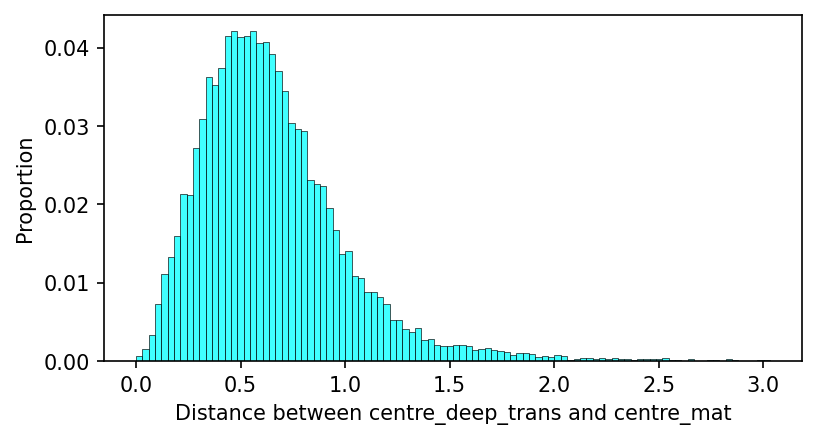

In [175]:
plot_euclidean_histogram(all_fpockets_w_sifts, "centre_deep_trans", "centre_mat", "cyan")
# this is because centre_fpocket comes from fpocket pocket atoms, and centre_fpocket_trans comes from all CA of residedues in centre_fpocket

72265


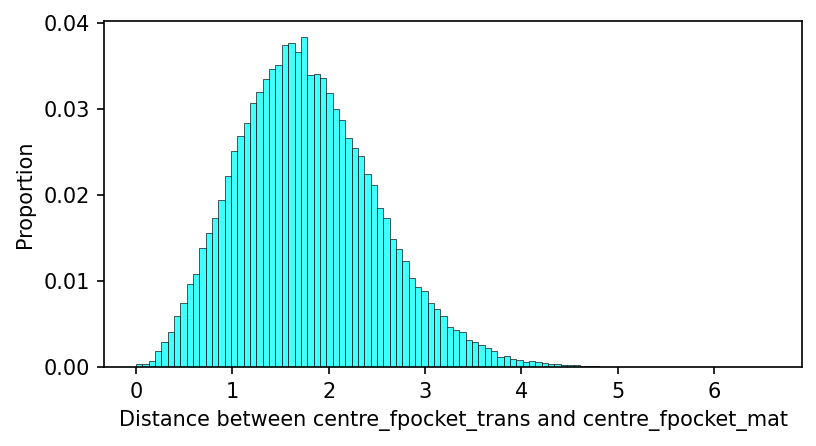

In [164]:
plot_euclidean_histogram(all_fpockets_w_sifts, "centre_fpocket_trans", "centre_fpocket_mat", "cyan")
# this is because centre_fpocket comes from fpocket pocket atoms, and centre_fpocket_trans comes from all CA of residedues in centre_fpocket

72265


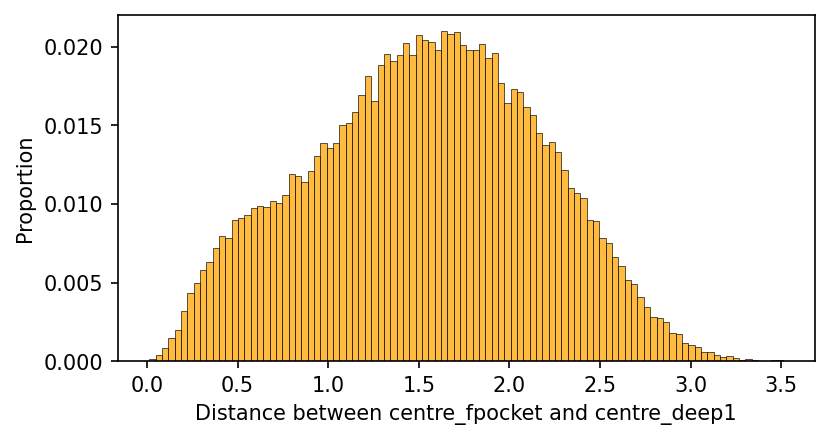

In [173]:
plot_euclidean_histogram(all_fpockets_w_sifts, "centre_fpocket", "centre_deep1")

72265


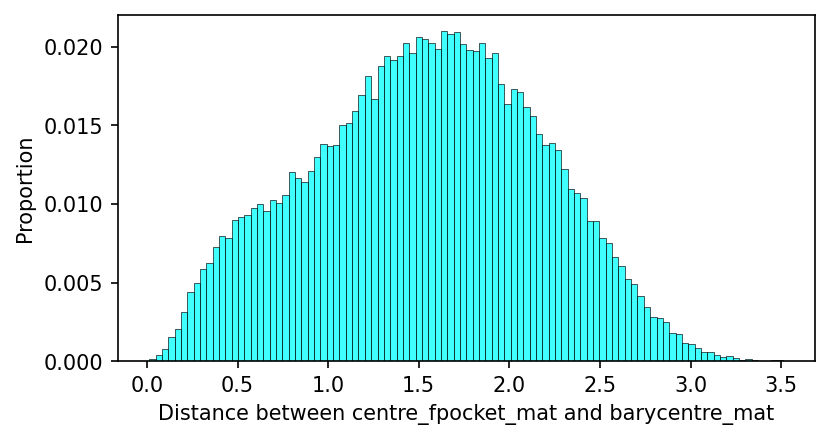

In [174]:
plot_euclidean_histogram(all_fpockets_w_sifts, "centre_fpocket_mat", "barycentre_mat", "cyan")

23615


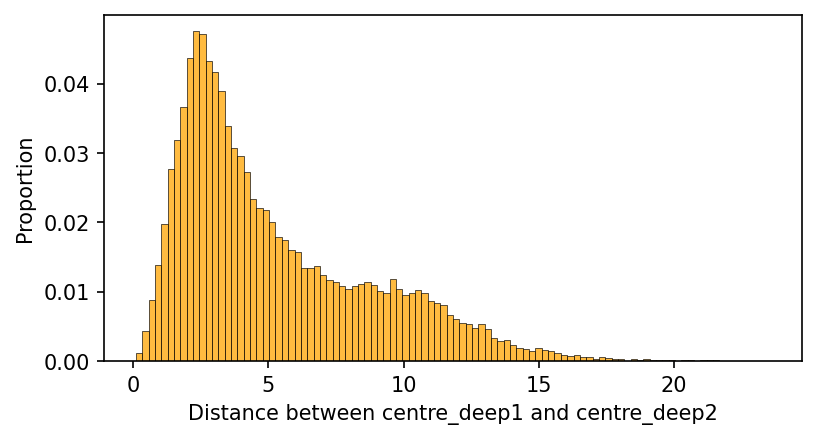

In [158]:
plot_euclidean_histogram(all_fpockets_w_sifts, "centre_deep1", "centre_deep2")

23615


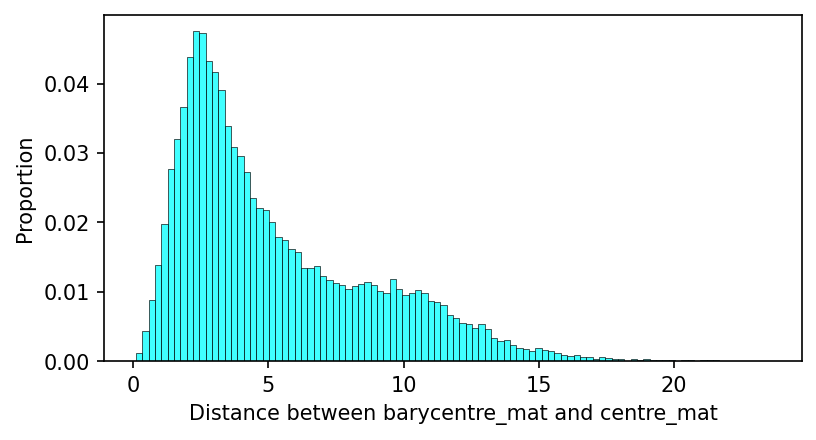

In [170]:
plot_euclidean_histogram(all_fpockets_w_sifts, "barycentre_mat", "centre_mat", "cyan")

In [160]:
def plot_euclidean_histogram(df, col1, col2, color = "orange"):
    # Helper function to calculate Euclidean distance
    def euclidean_distance(row):
        p1, p2 = row[col1], row[col2]
        return np.sqrt(np.sum((np.array(p1) - np.array(p2))**2))

    # Apply the distance calculation and drop NaN values
    df['IMP_DIST'] = df.apply(euclidean_distance, axis=1)
    distances = df['IMP_DIST'].dropna()
    print(len(distances))

    # Plotting the histogram
    plt.figure(figsize=(6,3), dpi=150)
    sns.histplot(distances, bins=100, stat="proportion", color=color)
    #plt.title("Distance Histogram")
    plt.xlabel(f"Distance between {col1} and {col2}")
    plt.ylabel("Proportion")
    plt.show()

In [146]:
all_fpockets_w_sifts[deeppocket_cols].head(3)

,rep_chain,ID,RANK_fpocket,score_fpocket,volume_fpocket,RoG_fpocket,n_aas_fpocket,aas_fpocket,up_aas_fpocket,centre_fpocket,...,RANK_deep,score_deep,RoG_deep,n_aas_deep,centre_deep1,centre_deep2,aas_deep,up_aas_deep,centre_mat,barycentre_mat
0,1a52_A,1,1,0.276,1190.393,11.82,32,"[47, 50, 51, 53, 54, 55, 57, 58, 62, 66, 71, 7...","[343, 346, 347, 349, 350, 351, 353, 354, 358, ...","(100.735, 15.502, 99.089)",...,1,0.973307,9.49,29.0,"(101.66, 14.74, 99.13)","(105.763, 14.673, 96.183)","[47, 50, 51, 53, 54, 55, 57, 58, 87, 88, 91, 9...","[343, 346, 347, 349, 350, 351, 353, 354, 383, ...","(0.308, -9.296, -1.867)","(-3.763, -7.518, 0.54)"
1,1a52_A,2,2,0.051,458.269,7.62,15,"[27, 28, 29, 30, 31, 57, 60, 61, 90, 91, 94, 9...","[323, 324, 325, 326, 327, 353, 356, 357, 386, ...","(103.727, 24.016, 103.754)",...,3,0.197817,NaN,NaN,"(104.03, 24.26, 104.0)",NaN,NaN,NaN,"(nan, nan, nan)","(1.808, -0.909, 7.267)"
2,1a52_A,3,3,0.027,443.436,6.97,10,"[155, 156, 159, 160, 183, 187, 212, 215, 216, ...","[451, 452, 455, 456, 479, 483, 508, 511, 512, ...","(94.882, 28.506, 89.855)",...,2,0.200280,8.15,12.0,"(93.83, 28.87, 88.54)","(91.899, 29.098, 90.534)","[155, 159, 160, 163, 180, 183, 184, 187, 212, ...","[451, 455, 456, 459, 476, 479, 480, 483, 508, ...","(-3.866, 10.545, -6.463)","(-1.927, 9.598, -8.223)"


In [151]:
len(all_fpockets_w_sifts.rep_chain.unique())

3571

In [119]:
#all_fpockets_w_sifts.to_pickle("./results/deeppocket_pockets_sifted_V2.pkl")

In [127]:
# all_fpockets_w_sifts_SASA.drop(
#     columns=[
#         'centre_deeppocket_trans',
#        ],
#     inplace=True
# )

## Add pocket surface and volumes

In [152]:
import importlib
import JSU_lib
importlib.reload(JSU_lib)
from JSU_lib import *

bad_reps = read_from_pickle("./results/OLD/other_errrors_reps.pkl")

#all_deeppockets_w_sifts = pd.read_pickle("./results/deeppocket_pockets_sifted_V2.pkl")

master_SASA_dict = read_from_pickle("./results/master_SASA_dict.pkl")

all_fpockets_w_sifts_SASA = calculate_total_sasa(all_fpockets_w_sifts, master_SASA_dict, column = 'aas_deep')

vols_dict = read_from_pickle("./results/DeepPocket_volumes_dict.pkl")

all_fpockets_w_sifts_SASA["VOL"] = all_fpockets_w_sifts_SASA.set_index(['rep_chain', 'ID']).index.map(vols_dict)

In [153]:
all_fpockets_w_sifts_SASA.query('VOL != VOL & aas_deep == aas_deep & rep_chain not in @bad_reps')

,score_fpocket,drug_score,n_alpha_spheres,total_sasa,polar_sasa,apolar_sasa,volume_fpocket,mean_hydro_density,mean_alpha_sphere_r,mean_alpha_sphere_solvent_acc,...,centre_mat,distance,barycentre_mat,barycentre_distance,centre_fpocket_mat,dist_fpocket_mat,up_aas_fpocket,up_aas_deep,SASA,VOL


In [154]:
all_fpockets_w_sifts_SASA.to_pickle("./results/DeepPocket_pockets_DEF_TRANS2.pkl")